In [23]:
import torch.nn.functional as F
import voc12.dataloader
import numpy as np
import argparse
import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from misc import pyutils, torchutils
from net.resnet50_cam import CAM, Net 
from misc import imutils
import matplotlib.pyplot as plt
from torch import nn
from net import resnet50

In [24]:
baseline_cam_weight_path = '/Users/Andy/Projects/resnet50_baseline_512.pth'
frontdoor_cam_weight_path = '/Users/Andy/Projects/resnet50_c2am.pth'

model_baseline = CAM()
model_frontdoor = CAM()
model_baseline.eval()
model_frontdoor.eval()
model_baseline.load_state_dict(torch.load(baseline_cam_weight_path, map_location='cpu'))
model_frontdoor.load_state_dict(torch.load(frontdoor_cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [31]:
train_list = '/Users/Andy/Projects/c2am/voc12/train.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

train_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(train_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
train_loader = DataLoader(val_dataset, shuffle=False)

val_list = '/Users/Andy/Projects/c2am/voc12/val.txt'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
val_loader = DataLoader(val_dataset, shuffle=False)

In [26]:
for pack in train_loader:
    name = pack['name'][0]
    # print(name)
    if name == '2008_004430':
        print(pack['label'][0])
        break

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])


In [27]:
with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    print(img_name)

    strided_up_size = imutils.get_strided_up_size(size, 16)

    baseline_outputs = [model_baseline(img[0]) for img in pack['img']]
    frontdoor_outputs = [model_frontdoor(img[0]) for img in pack['img']]

    baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
    baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]
    
    frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
    frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    baseline_highres_cam = baseline_highres_cam[valid_cat]
    frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
    baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5
    frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5

2008_004430


2008_004430


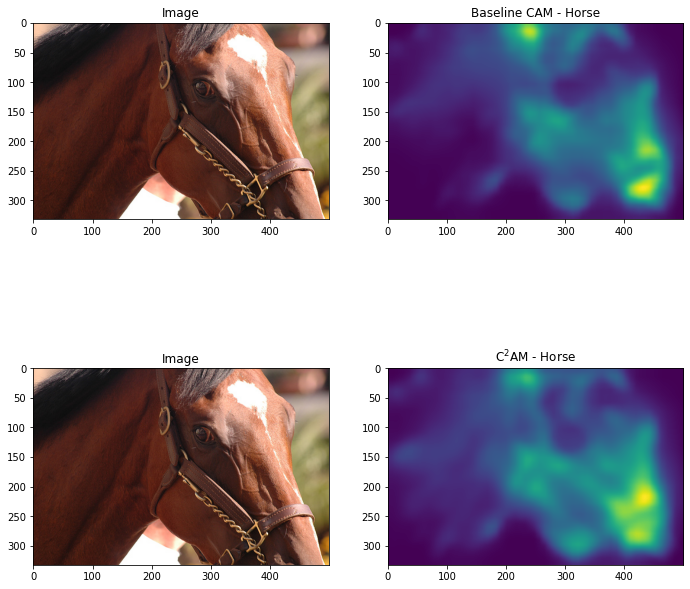

In [28]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
print(img_name)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Horse')
ax2.imshow(baseline_highres_cam[0].squeeze())
ax1 = fig.add_subplot(334)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(335)
plt.title('C$^2$AM - Horse')
ax2.imshow(frontdoor_highres_cam[0].squeeze())

In [32]:
data_iter = iter(val_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']
    print(img_name)

    strided_up_size = imutils.get_strided_up_size(size, 16)

    baseline_outputs = [model_baseline(img[0]) for img in pack['img']]
    frontdoor_outputs = [model_frontdoor(img[0]) for img in pack['img']]

    baseline_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in baseline_outputs]
    baseline_highres_cam = torch.sum(torch.stack(baseline_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]
    
    frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
    frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    baseline_highres_cam = baseline_highres_cam[valid_cat]
    frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
    baseline_highres_cam /= F.adaptive_max_pool2d(baseline_highres_cam, (1, 1)) + 1e-5
    frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5

2007_000129


2007_000129


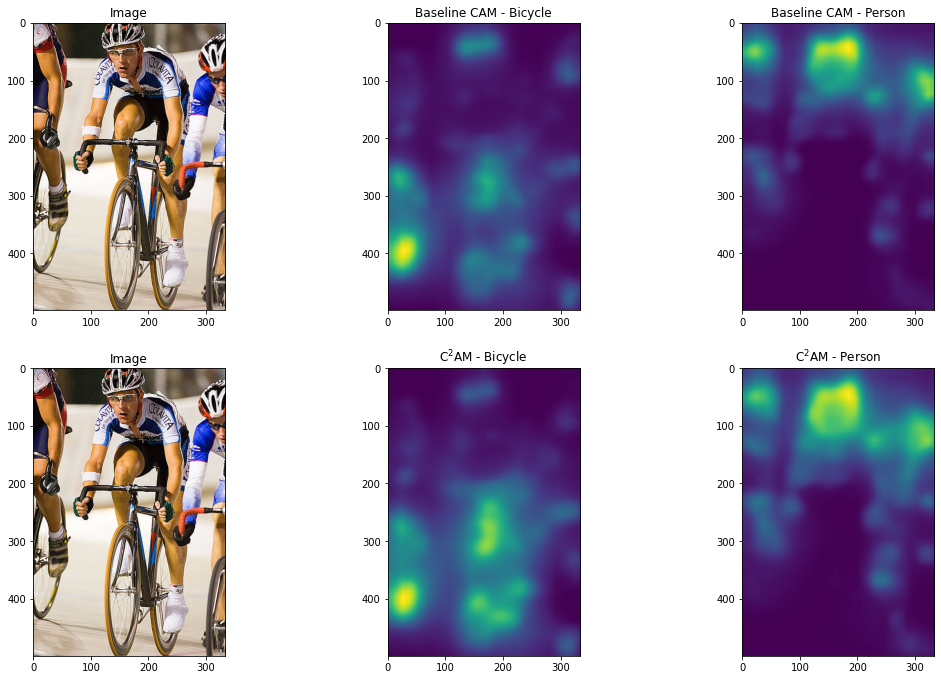

In [35]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', img_name + '.jpg'))
print(img_name)
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Bicycle')
ax2.imshow(baseline_highres_cam[0].squeeze())
ax3 = fig.add_subplot(333)
plt.title('Baseline CAM - Person')
ax3.imshow(baseline_highres_cam[1].squeeze())
ax1 = fig.add_subplot(334)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(335)
plt.title('C$^2$AM - Bicycle')
ax2.imshow(frontdoor_highres_cam[0].squeeze())
ax3 = fig.add_subplot(336)
plt.title('C$^2$AM - Person')
ax3.imshow(frontdoor_highres_cam[1].squeeze())

In [77]:
import cv2

def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = True,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [26]:
people_cam = baseline_highres_cam[14].squeeze()
norm_image = cv2.normalize(np.asarray(im), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

overlap = show_cam_on_image(norm_image, people_cam)

im_n = Image.fromarray(overlap)
im_n.show()

# Causal Class Activation Maps

Consider the following Causal Graph, this graph depicted the causal relationship between the image $X$ and its weak localization mask $Y$. The tag $Z$ is the image-level label assigned to each image. For instance, it could be "bicycle" and "person" for the image above. Moreover, we assume that each observed image $X$ has a generation process based on latent confounder $C_z$.

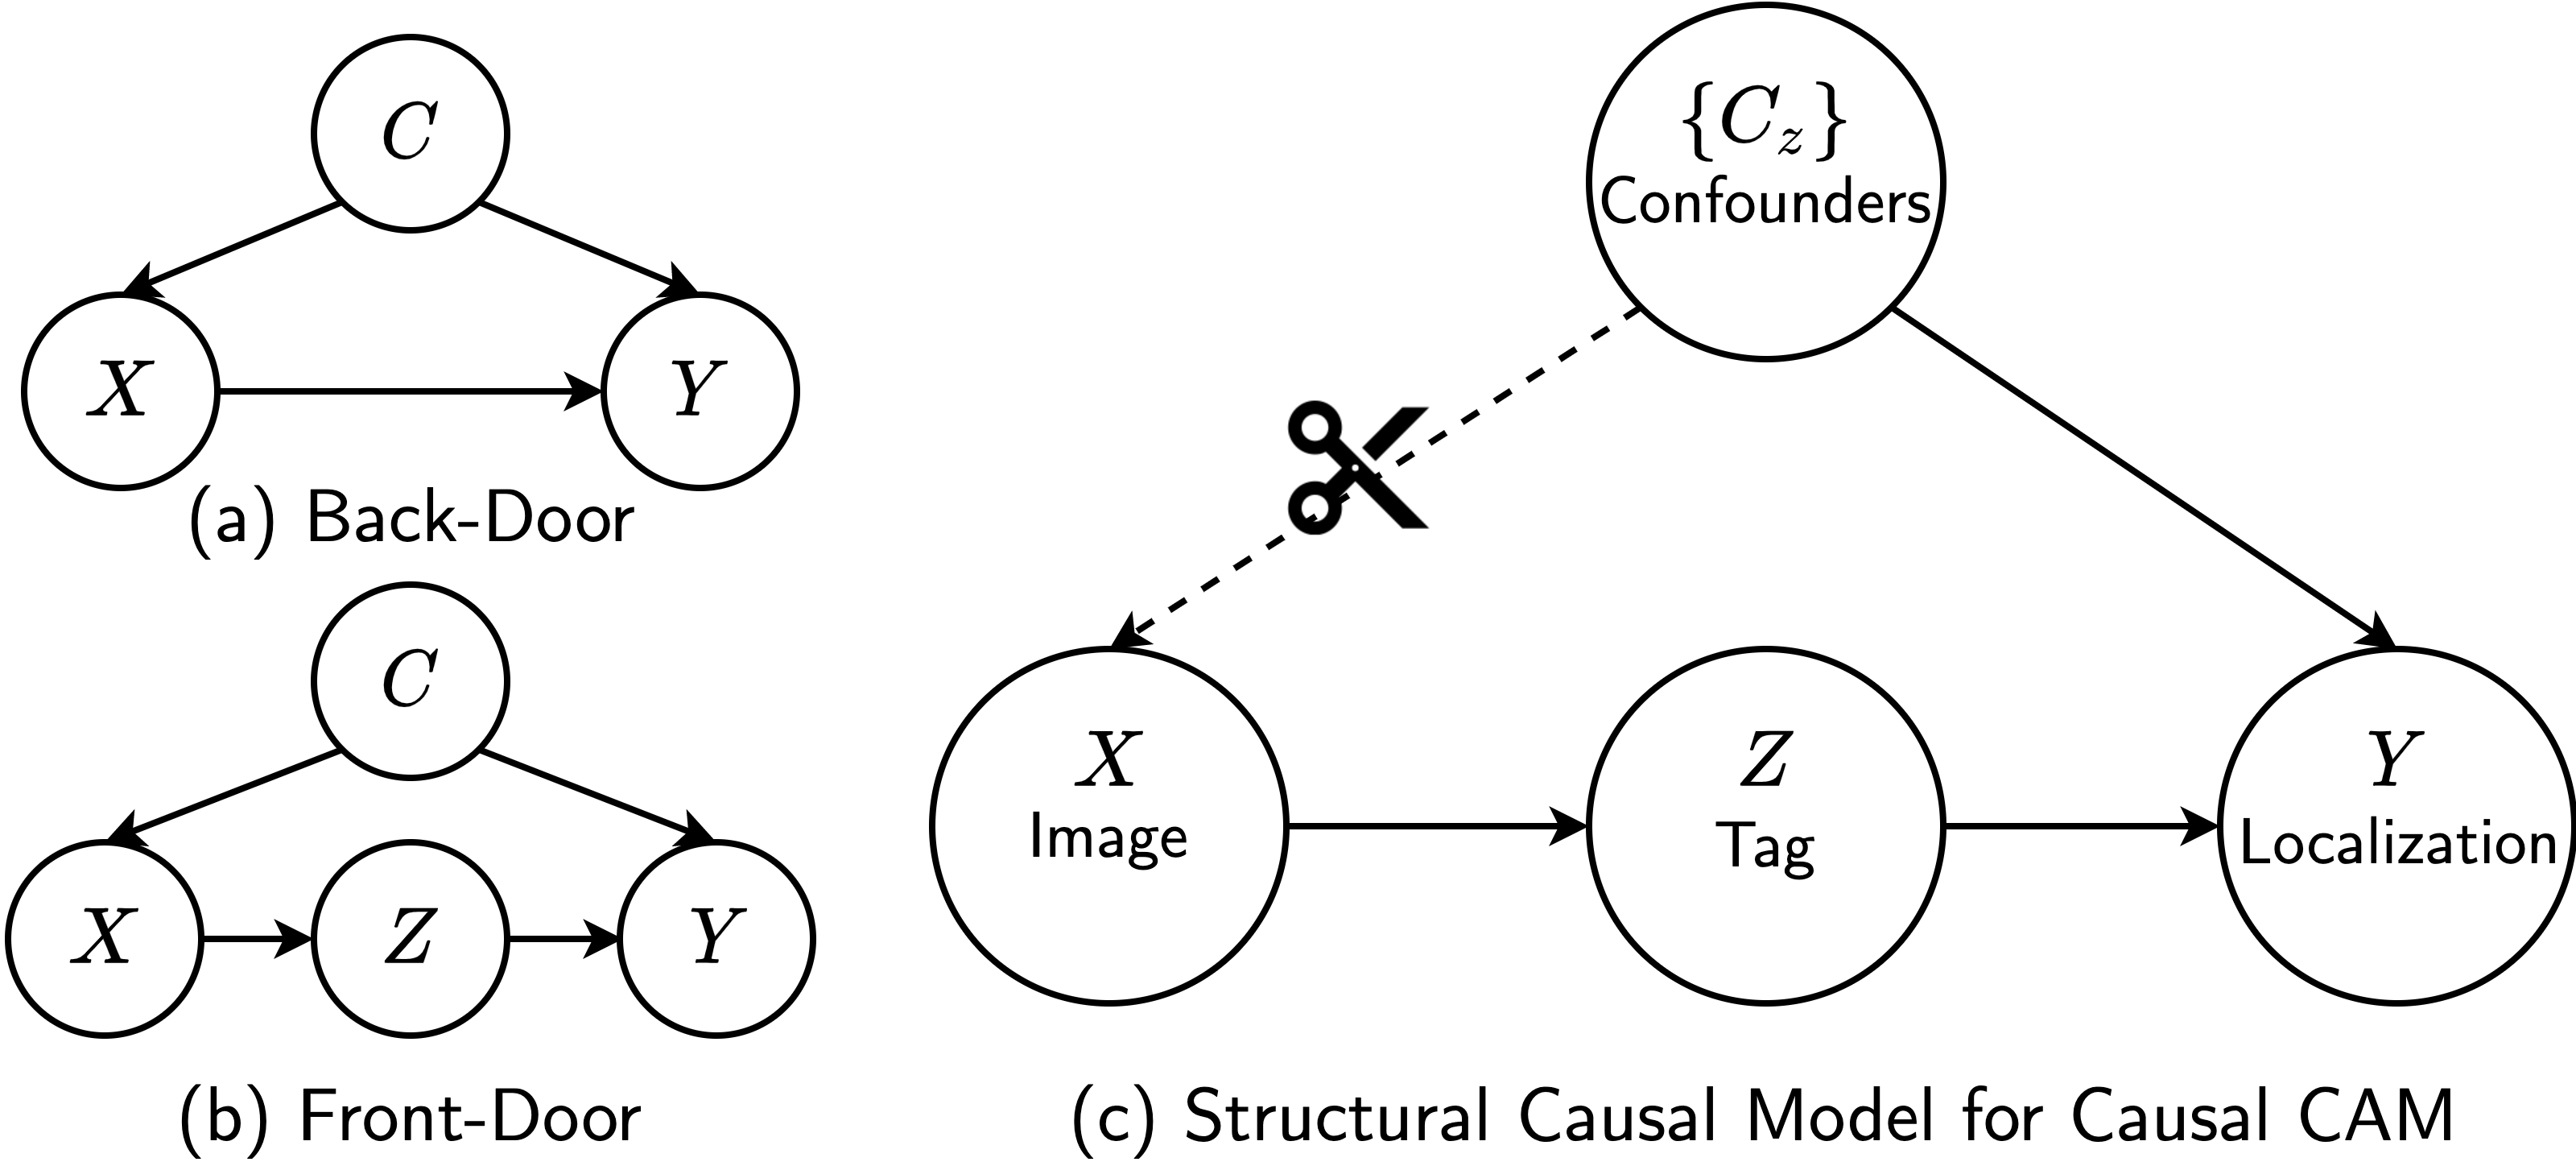

$C\rightarrow X$ and $C\rightarrow Y$. The content prior $C$ identifies the objects (e.g., people and bicycle) and pictures the relationships among objects (e.g. person on the bicycle) in a scene. Hence, it determines what to picture in an image $X$. Moreover, it also causes weak localization results $Y$. 

$X\rightarrow Z$. The tag $Z$ of an image is determined by the image $X$, as the tags are annotated by human-selected classes, instead of annotating every class of objects. Thus, content prior $C$ cannot directly affect the labels $Z$ of an image. 

$Z\rightarrow Y$. The weak localization masks $Y$ are determined by the tag $Z$ as the tag(s) restricts the object to be localized. For instance, if the background of an image contains semantic objects, if the tag doesn't include that class of the object, the localization mask $Y$ will assign "background" to those pixels.


## Causal Intervenetion by Front-Door Adjustment
Based on the causal diagram, we can see content $C$ confounds $X$ and $Y$ via the backdoor path from $X$ to $Y$. However, $C$ is unobservable and hence cannot be used to block the backdoor path from $X$ to $Y$. Nevertheless, by applying two consecutive applications of the backdoor criterion, we can identify the causal effect $P(Y = y|do(X=x))$. This is also known as the **Front-Door Adjustment**. 


# Front-Door Adjustment for Weakly-Supervised Semantic Segmentation

- $P(z|x)$: A classification network trained on the dataset will produce a probability distribution $P(z|x)$ over the given classes in a dataset. For instance, in PASCAL VOC, it will be $B\times 20$. 
- $P(y|x, z)$: With the class activation map, we also can estimate $P(y|x, z)$ which contains the attention map over the given classes in a dataset. For instance, in PASCAL VOC, it will be $B\times 20 \times H \times W$.
- $P(x)$: Under the assumption $P(x)$ is uniform, i.e., $\frac{1}{N}$ where $N$ is the number of images in a given dataset. This assumption is reasonable as the training samples are equiprobable. 

However, the tricky part of utilizing front-door adjustment is the summations over all $x$ in the dataset, i.e., $\sum_{x'}P(y|x',z)P(x')$.  

## Compute $\sum_{x'}P(y|x',z)P(x')$
It is actually fast to compute $P(y|x',z)$ for the entire training set, by utilizing parallel computing. It takes about three minutes to compute all CAMs for the training set of the PASCAL VOC 2012 classification partition. 